In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import cauchy, gamma

import emcee
print(emcee.__version__)

import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Deterministic, Normal, Gamma, StudentT, Empirical, NormalWithSoftplusScale, Exponential

import itertools
import time

2.2.1


### Data

We generate 1 million samples from the Gaussian distribution with the model parameters:

1. <b>delta</b> ~ cauchy(0, 1)
2. <b>mu</b> ~ cauchy(0, 1)
3. <b>sigma</b> ~ gamma(2, 2)
4. <b>alpha</b> = delta * sigma
5. <b>x</b> ~ normal(mu+alpha, sigma)
6. <b>y</b> ~ normal(mu, sigma)

In [12]:
num_points = 1000000 # [100, 10000, 1000000]

In [13]:
def generate_data_normal(N):
    delta = 2.0
    mu = 0.0
    sigma = 1.0
    alpha = delta * sigma
    
    xdata = np.random.normal(mu+alpha, sigma, N)
    ydata = np.random.normal(mu, sigma, N)
    return (xdata, ydata)

In [14]:
def plot_points(x, y):
    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ok', markersize=3)
    plt.grid()
    plt.show()

In [15]:
def plot_data_hist(x, y):
    plt.figure(figsize=(10,5))
    plt.hist(x, alpha=0.5, bins=500, label="X data")
    plt.hist(y, alpha=0.5, bins=500, label="Y data")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()
    
def plot_trace_hist(trace):
    trace = trace[trace < 1]
    plt.hist(trace, alpha=0.5, bins=500, label="delta")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

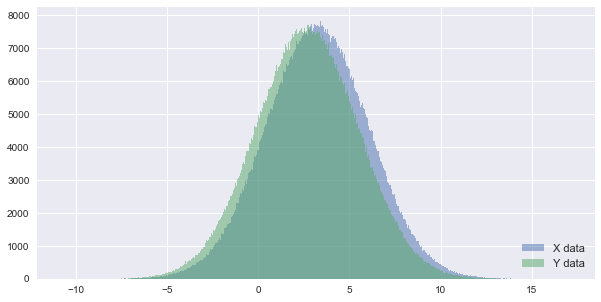

In [16]:
np.random.seed(42)
xdata, ydata = generate_data_normal(num_points)
plot_data_hist(xdata, ydata)

Further we will investigate sampling package [Emcee](https://github.com/dfm/emcee) and variational inference using [Edward](https://github.com/blei-lab/edward) package.

# Emcee

In [17]:
_xdata = np.array(xdata, dtype=float)
_ydata = np.array(ydata, dtype=float)

assert(all(np.isnan(_xdata)) == False)
assert(all(np.isnan(_ydata)) == False)

In [18]:
def lnprior(theta):
    delta, mu, sigma = theta
    
    prob_delta = cauchy.pdf(delta, 0, 1)
    prob_mu = cauchy.pdf(mu, 0, 1)
    prob_sigma = gamma.pdf(sigma, 2, 2)
    
    if prob_sigma <= 0:
        return -np.inf
    else:
        return np.log(prob_delta) + np.log(prob_mu) + np.log(prob_sigma)
    
    
def lnlike(theta, x, y):
    delta, mu, sigma = theta
    
    log_coeff = np.log( 1 / np.sqrt(2 * np.pi * sigma**2) )
    denom = 2 * (sigma ** 2)
    x_g = ( (x - (mu + delta/sigma))**2 ) / denom
    y_g = ( (y - mu)**2 ) / denom
                
    return (2 * log_coeff) - x_g - y_g 

def lnposterior(theta, x, y):
    return lnprior(theta) + lnlike(theta, x, y)

In [19]:
ndim = 3  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
starting_guesses = np.random.random((nwalkers, ndim))

In [20]:
start_time = time.time()

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=[xdata, ydata])
sampler.run_mcmc(starting_guesses, nsteps)

end_time = time.time()

/Users/ddedik/anaconda2/envs/py3k/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ddedik/anaconda2/envs/py3k/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


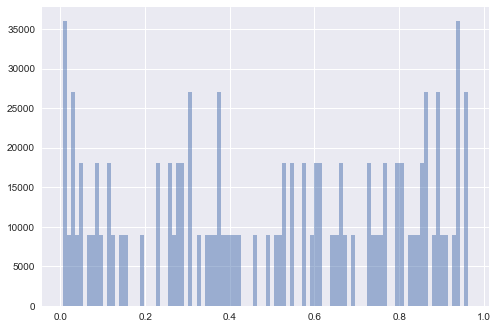

--- emcee sampling vi 12907.430394887924 seconds ---


In [21]:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plt.hist(emcee_trace[0], alpha=0.5, bins=100, label="delta")
plt.show()
print("--- emcee sampling vi %s seconds ---" % (end_time - start_time))

# Edward

### Data

In [2]:
sess = ed.get_session()

In [4]:
# FORWARD MODEL, Prior
mu = StudentT(1.0,[0.0],[1.0])
delta = StudentT(1.0,[0.0],[1.0])
sigma = Gamma([2.0],[2.0])
alpha = delta * sigma

In [18]:
x = Normal(tf.tile(mu+alpha,[num_points]), tf.tile(sigma,[num_points]))
y = Normal(tf.tile(mu,[num_points]), tf.tile(sigma,[num_points]))

In [19]:
# BACKWARD MODEL
q_mu = NormalWithSoftplusScale(loc=tf.Variable([0.0]), scale=tf.Variable([1.0]))
q_sigma = Gamma(tf.nn.softplus(tf.Variable([1.0])), tf.nn.softplus(tf.Variable([1.0])))
q_delta = NormalWithSoftplusScale(loc=tf.Variable([0.0]), scale=tf.Variable([1.0]))

In [20]:
# INFERENCE
inference = ed.KLqp({delta: q_delta, mu: q_mu, sigma: q_sigma}, data={x: xdata, y: ydata})

In [21]:
start_time = time.time()
inference.run(n_iter=10000, n_print=200, n_samples=50)
end_time = time.time()
print("--- Edward vi %s seconds ---" % (end_time - start_time))

2000/2000 [100%] ██████████████████████████████ Elapsed: 28s | Loss: 68147.227
--- Edward vi 28.207113027572632 seconds ---


In [ ]:
T = 10000
delta_sample = sess.run(delta.sample(sample_shape=T))
q_delta_sample = sess.run(q_delta.sample(sample_shape=T))

In [ ]:
plt.subplot(211)
plt.hist(delta_sample, bins=100, label='delta samples')
plt.legend(loc='upper right', fontsize=16)
plt.grid(True)
plt.xlim(-1000, 1000)

plt.subplot(212)
plt.hist(q_delta_sample, bins=100, label='q_delta samples')
plt.legend(loc='upper right', fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
print(('delta mu: {}, delta scale: {}').format(q_delta.parameters['loc'].eval(), q_delta.parameters['scale'].eval()))

In [ ]:
# Alternative set-up

In [ ]:
# FORWARD MODEL
mu = StudentT(1.0,[0.5],[1.0])
delta = StudentT(1.0,[0.5],[1.0])
sigma = Gamma([2.0],[2.0])
alpha = delta * sigma

In [ ]:
x = Normal(tf.tile(mu + alpha,[num_points]), tf.tile(sigma,[num_points]))
y = Normal(tf.tile(mu,[num_points]), tf.tile(sigma,[num_points]))

In [ ]:
# BACKWARD MODEL
np.random.seed(42)
q_delta_loc = tf.Variable(tf.random_normal([]))
q_delta_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

q_sigma_loc = tf.Variable(tf.random_normal([]))
q_sigma_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

q_mu_loc = tf.Variable(tf.random_normal([]))
q_mu_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

q_mu = NormalWithSoftplusScale(q_mu_loc, q_mu_scale, sample_shape=1)
q_sigma = Gamma(q_sigma_loc, q_sigma_scale, sample_shape=1)
q_delta = NormalWithSoftplusScale(q_delta_loc, q_delta_scale, sample_shape=1)

In [ ]:
# INFERENCE
inference = ed.KLqp({delta: q_delta, mu: q_mu, sigma: q_sigma}, data={x: xdata, y: ydata})
inference.run(n_iter=10000, n_print=200, n_samples=10)

In [ ]:
print(('delta mu: {}, delta scale: {}').format(q_delta.parameters['loc'].eval(), q_delta.parameters['scale'].eval()))

In [ ]:
T = 10000
delta_sample = sess.run(delta.sample(sample_shape=T))
q_delta_sample = sess.run(q_delta.sample(sample_shape=T))

In [ ]:
plt.subplot(211)
plt.hist(delta_sample, bins=100, label='delta samples')
plt.legend(loc='upper right', fontsize=16)
plt.xlim(-1000, 1000)

plt.subplot(212)
plt.hist(q_delta_sample, bins=100, label='q_delta samples')
plt.legend(loc='upper right', fontsize=16)
plt.show()